In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import keras

dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC,generate_representation, median_filter

folder = "../../KOI_Data/"
folder_lc = "/work/work_teamEXOPLANET/KOI_LC/"

Using TensorFlow backend.


### Read light curves
> From Kepler or all others

In [2]:
time_kepler = np.load(folder_lc+"npy/KOI_LC_time.npy")
lc_kepler = np.load(folder_lc+"npy/KOI_LC_init.npy" )
N, T = lc_kepler.shape
print((N,T))

(8054, 71427)


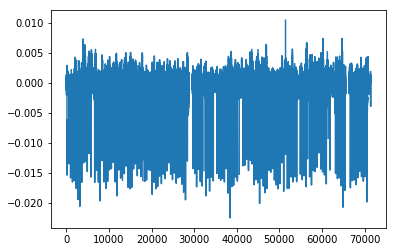

In [3]:
plt.plot(lc_kepler[0])
plt.show()

### Pre-process (clean lc)
> And save it

In [3]:
process_lc = []
for i in range(N):
    if i%1000 == 0:
        print("Va en el ",i)
    lc_cleaned = clean_LC(lc_kepler[i], kernel_median=25, kernel_pol=151, detrend_median=False, plot=False) 
    process_lc.append(lc_cleaned)
process_lc = np.asarray(process_lc)
process_lc.shape

Va en el  0


/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/users/fmena/PIIC19/code/pre_process.py:120: RuntimeWarning: invalid value encountered in less
  mask_nan = (f_clean - med < -sigm_low * MAD) | (f_clean - med > sigm_up * MAD)
/users/fmena/PIIC19/code/pre_process.py:120: RuntimeWarning: invalid value encountered in greater
  mask_nan = (f_clean - med < -sigm_low * MAD) | (f_clean - med > sigm_up * MAD)


Clean done (remove outliers iterativetly), erase 3 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 152 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 53 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 47 values
Clean done (remove outliers iterativetly), erase 16 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 269 values
Clean done (remove outliers iterativetly), erase 2 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 4 values


Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 17 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 2 values
Clean done (remove outliers iterativetly), erase 18 values
Clean done (remove outliers iterativetly), erase 35 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 35 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 2 values
Cl

Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 166 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 16 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 17 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 0 values


Clean done (remove outliers iterativetly), erase 19 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 18 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 18 values
Clean done (remove outliers iterativetly), erase 18 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 10 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 3 values
Clean done (remove outliers iterativetly), erase 19 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 13 values
C

Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 35 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 50 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 38 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 3 values
Clean done (remove outliers iterativetly), erase 19 values
Clean done (remove outliers iterativetly), erase 102 values
Clean done (remove outliers iterativetly), erase 5 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 2 values
Cle

Clean done (remove outliers iterativetly), erase 19 values
Clean done (remove outliers iterativetly), erase 119 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 18 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 7 values
Clean done (remove outliers iterativetly), erase 0 values


Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 178 values
Clean done (remove outliers iterativetly), erase 5 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 39 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 41 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 54 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 16 values
Cle

Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 38 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 300 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 35 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 40 values
Clean done (remove outliers iterativetly), erase 56 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 41 values
Clean done (remove outliers iterativetly), erase 49 values
Clean done (remove outliers iterativetly), erase 0 values

Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 72 values
Clean done (remove outliers iterativetly), erase 7 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 50 values
Clean done (remove outliers iterativetly), erase 38 values
Clean done (remove outliers iterativetly), erase 428 values
Clean done (remove outliers iterativetly), erase 21 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 40 values
Clean done (remove outliers iterativetly), erase 52 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 39 values
Clean done (remove outliers iterativetly), erase 26 value

Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 17 values
Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 12 values
Clean done (remove outliers iterativetly), erase 379 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 46 values
Clean done (remove outliers iterativetly), erase 48 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 63 values


Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 481 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 19 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 706 values
Clean done (remove outliers iterativetly), erase 17 values
Clean done (remove outliers iterativetly), erase 16 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 21 values
Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 43 values
Clean done (remove outliers iterativetly), erase 47 values


Clean done (remove outliers iterativetly), erase 38 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 3 values
Clean done (remove outliers iterativetly), erase 40 values
Clean done (remove outliers iterativetly), erase 46 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 68 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 59 values
Clean done (remove outliers iterativetly), erase 16 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 3 values
Clean done (remove outliers iterativetly), erase 5 values
Clean done (remove outliers iterativetly), erase 22 values
C

Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 18 values
Clean done (remove outliers iterativetly), erase 21 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 16 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 31 values
Cl

Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 42 values
Clean done (remove outliers iterativetly), erase 38 values
Clean done (remove outliers iterativetly), erase 16 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 138 values
Clean done (remove outliers iterativetly), erase 42 values
Clean done (remove outliers iterativetly), erase 44 values
Clean done (remove outliers iterativetly), erase 11 values


Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 64 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 21 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 58 values
Clean done (remove outliers iterativetly), erase 48 values
Clean done (remove outliers iterativetly), erase 4 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 25 values


Clean done (remove outliers iterativetly), erase 174 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 2 values
Clean done (remove outliers iterativetly), erase 19 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 19 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 11 values
Clean done (remove outliers iterativetly), erase 18 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 24 value

Clean done (remove outliers iterativetly), erase 21 values
Clean done (remove outliers iterativetly), erase 40 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 44 values
Clean done (remove outliers iterativetly), erase 6 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 35 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 60 values
Clean done (remove outliers iterativetly), erase 57 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 157 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 21 values
Clean done (remove outliers iterativetly), erase 26 value

Clean done (remove outliers iterativetly), erase 2 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 9 values
Clean done (remove outliers iterativetly), erase 46 values
Clean done (remove outliers iterativetly), erase 2 values
Clean done (remove outliers iterativetly), erase 45 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 80 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 23 values
Cl

Clean done (remove outliers iterativetly), erase 6 values
Clean done (remove outliers iterativetly), erase 35 values
Clean done (remove outliers iterativetly), erase 39 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 354 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 12 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 18 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 30 values
C

Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 41 values
Clean done (remove outliers iterativetly), erase 39 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 10 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 7 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 5 values
Clean done (remove outliers iterativetly), erase 11 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 24 values
Cl

Clean done (remove outliers iterativetly), erase 11 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 13 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 35 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 38 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 1 values
Cl

Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 17 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 161 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 12 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 1 value

Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 8 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 56 values
Clean done (remove outliers iterativetly), erase 16 values
Clean done (remove outliers iterativetly), erase 83 values
Clean done (remove outliers iterativetly), erase 118 values
Clean done (remove outliers iterativetly), erase 38 values
Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 6 values
Clean done (remove outliers iterativetly), erase 43 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 4 values
Clean done (remove outliers iterativetly), erase 27 values


Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 39 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 39 values
Clean done (remove outliers iterativetly), erase 43 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 26 values


Clean done (remove outliers iterativetly), erase 185 values
Clean done (remove outliers iterativetly), erase 172 values
Clean done (remove outliers iterativetly), erase 145 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 17 values
Clean done (remove outliers iterativetly), erase 19 values
Clean done (remove outliers iterativetly), erase 19 values
Clean done (remove outliers iterativetly), erase 46 values
Clean done (remove outliers iterativetly), erase 2 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 38 values
Clean done (remove outliers iterativetly), erase 25 va

Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 293 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 71 values
Clean done (remove outliers iterativetly), erase 12 values
Clean done (remove outliers iterativetly), erase 44 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 11 values
Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 34 value

Clean done (remove outliers iterativetly), erase 39 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 12 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 7 values
Clean done (remove outliers iterativetly), erase 16 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 2 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 27 values


Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 16 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 17 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 17 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 6 values
Clean done (remove outliers iterativetly), erase 18 values
C

Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 19 values
Clean done (remove outliers iterativetly), erase 48 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 12 values
Clean done (remove outliers iterativetly), erase 11 values
Clean done (remove outliers iterativetly), erase 39 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 16 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 12 values
Clean done (remove outliers iterativetly), erase 24 values


Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 11 values
Clean done (remove outliers iterativetly), erase 2 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 8 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 50 values
Clean 

Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 8 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 9 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 18 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 11 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 82 values
Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 22 values

Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 46 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 4 values
Clean done (remove outliers iterativetly), erase 35 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 0 values


Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 2 values
Clean done (remove outliers iterativetly), erase 40 values
Clean done (remove outliers iterativetly), erase 54 values
Clean done (remove outliers iterativetly), erase 21 values
Clean done (remove outliers iterativetly), erase 7 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 18 values
Clean done (remove outliers iterativetly), erase 17 values
Clean done (remove outliers iterativetly), erase 35 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 42 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 36 values
C

Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 78 values
Clean done (remove outliers iterativetly), erase 186 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 35 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 16 values
Clean done (remove outliers iterativetly), erase 21 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 35 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 0 values

Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 2 values
Clean done (remove outliers iterativetly), erase 6 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 21 values
Clean done (remove outliers iterativetly), erase 18 values
Clean done (remove outliers iterativetly), erase 16 values
Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 6 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 33 values
C

Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 10 values
Clean done (remove outliers iterativetly), erase 9 values
Clean done (remove outliers iterativetly), erase 9 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 8 values
Clean done (remove outliers iterativetly), erase 3 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 38 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 63 values
Clean done (remove outliers iterativetly), erase 48 values
Clean

Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 4 values


Clean done (remove outliers iterativetly), erase 21 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 3 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 38 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 11 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 58 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 27 values


Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 74 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 9 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 77 values
Clean done (remove outliers iterativetly), erase 18 values
C

Clean done (remove outliers iterativetly), erase 12 values
Clean done (remove outliers iterativetly), erase 4 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 47 values
Clean done (remove outliers iterativetly), erase 41 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 77 values
Clean done (remove outliers iterativetly), erase 372 values
Clean done (remove outliers iterativetly), erase 45 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 40 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 39 values
Clean done (remove outliers iterativetly), erase 39 values
Clean done (remove outliers iterativetly), erase 24 value

Clean done (remove outliers iterativetly), erase 40 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 45 values
Clean done (remove outliers iterativetly), erase 64 values
Clean done (remove outliers iterativetly), erase 17 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 371 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 18 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 25 values


Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 54 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 38 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 4 values
Clean done (remove outliers iterativetly), erase 10 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 44 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 36 values


Clean done (remove outliers iterativetly), erase 96 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 53 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 39 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 17 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 136 values
Clean done (remove outliers iterativetly), erase 0 values
C

Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 39 values
Clean done (remove outliers iterativetly), erase 39 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 46 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 35 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 45 value

Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 39 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 89 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 30 values
C

Clean done (remove outliers iterativetly), erase 47 values
Clean done (remove outliers iterativetly), erase 45 values
Clean done (remove outliers iterativetly), erase 43 values
Clean done (remove outliers iterativetly), erase 40 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 44 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 51 values
Clean done (remove outliers iterativetly), erase 133 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 42 values
Clean done (remove outliers iterativetly), erase 17 values
Clean done (remove outliers iterativetly), erase 35 value

Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 21 values
Clean done (remove outliers iterativetly), erase 18 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 21 values
Clean done (remove outliers iterativetly), erase 15 values
Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 12 values
Clean done (remove outliers iterativetly), erase 16 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 10 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 16 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 36 values


Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 52 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 47 values
Clean done (remove outliers iterativetly), erase 38 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 41 values


Clean done (remove outliers iterativetly), erase 43 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 51 values
Clean done (remove outliers iterativetly), erase 43 values
Clean done (remove outliers iterativetly), erase 74 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 153 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 21 values
Clean done (remove outliers iterativetly), erase 25 values

Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 47 values
Clean done (remove outliers iterativetly), erase 44 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 39 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 35 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 5 values
Clean done (remove outliers iterativetly), erase 19 values
C

Clean done (remove outliers iterativetly), erase 17 values
Va en el  7000
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 9 values
Clean done (remove outliers iterativetly), erase 35 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 18 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 5 values
Clean done (remove outliers iterativetly), 

Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 21 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 74 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 53 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 16 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 33 values

Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 20 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 3 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 2 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 44 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 197 values
Clean done (remove outliers iterativetly), erase 23 values
Clean done (remove outliers iterativetly), erase 78 values
Clean done (remove outliers iterativetly), erase 28 values
Clean

Clean done (remove outliers iterativetly), erase 38 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 38 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 12 values
Clean done (remove outliers iterativetly), erase 18 values
Clean done (remove outliers iterativetly), erase 55 value

Clean done (remove outliers iterativetly), erase 45 values
Clean done (remove outliers iterativetly), erase 3 values
Clean done (remove outliers iterativetly), erase 38 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 42 values
Clean done (remove outliers iterativetly), erase 38 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 46 values
Clean done (remove outliers iterativetly), erase 49 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 25 values


Clean done (remove outliers iterativetly), erase 21 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 33 values
Clean done (remove outliers iterativetly), erase 7 values
Clean done (remove outliers iterativetly), erase 1 values
Clean done (remove outliers iterativetly), erase 38 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 2 values
Clean done (remove outliers iterativetly), erase 24 values
Clean done (remove outliers iterativetly), erase 4 values
Clean done (remove outliers iterativetly), erase 16 values
Clean done (remove outliers iterativetly), erase 19 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 600 values
Clean done (remove outliers iterativetly), erase 28 values
Cl

Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 36 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 39 values
Clean done (remove outliers iterativetly), erase 50 values
Clean done (remove outliers iterativetly), erase 52 values
Clean done (remove outliers iterativetly), erase 37 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 31 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 27 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 9 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 33 values

Clean done (remove outliers iterativetly), erase 14 values
Clean done (remove outliers iterativetly), erase 26 values
Clean done (remove outliers iterativetly), erase 21 values
Clean done (remove outliers iterativetly), erase 22 values
Clean done (remove outliers iterativetly), erase 42 values
Clean done (remove outliers iterativetly), erase 30 values
Clean done (remove outliers iterativetly), erase 25 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 34 values
Clean done (remove outliers iterativetly), erase 2 values
Clean done (remove outliers iterativetly), erase 32 values
Clean done (remove outliers iterativetly), erase 0 values
Clean done (remove outliers iterativetly), erase 45 values
Clean done (remove outliers iterativetly), erase 29 values
Clean done (remove outliers iterativetly), erase 28 values
Clean done (remove outliers iterativetly), erase 44 values
Clean done (remove outliers iterativetly), erase 25 values

(8054, 71427)

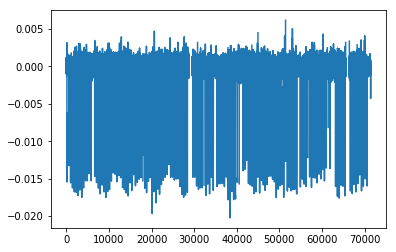

In [7]:
plt.plot(process_lc[0])
plt.show()

In [4]:
#save on another folder
np.save(folder_lc+'/cleaned/LC_kepler_processed.npy', process_lc)

In [19]:
process_lc = np.load(folder_lc+'/cleaned/LC_kepler_processed.npy')
process_lc

array([[-3.34071740e-04, -9.56036533e-04, -3.20341756e-04, ...,
         9.60861553e-05, -4.28106840e-03, -1.24094493e-04],
       [            nan,             nan,             nan, ...,
         2.43145845e-04,  5.07318850e-04,  7.28473887e-04],
       [            nan,             nan,             nan, ...,
        -5.09219964e-04, -6.28478091e-04, -4.82152588e-04],
       ...,
       [-4.26950242e-04,  6.72681813e-04, -5.06025675e-04, ...,
         1.17988662e-04,  5.61176640e-04, -8.82411989e-04],
       [-3.78445133e-04,  7.17432038e-04, -4.64985683e-04, ...,
         1.27586012e-04,  5.71776436e-04, -8.70897239e-04],
       [-1.71322380e-05, -1.38334626e-04,  8.02269873e-04, ...,
         4.07656344e-04, -1.24859904e-03, -4.05257242e-04]])

### Generate representation
> Continous values (with zeros)  
> Coupled values (adding time)

In [20]:
#do it..
for i in range(N):
    if i%1000 == 0:
        print("Va en el ",i)
    time_kepler[i], process_lc[i] = generate_representation(time_kepler[i], process_lc[i])

Va en el  0
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423941 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423941 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampli

New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old le

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423942 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old le

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423943 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old le

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old le

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old le

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423944 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old le

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old le

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423945 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old le

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is b

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423946 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423947 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************M

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423948 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423949 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423950 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423951 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old le

New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
Va en el  8000
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423953 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423952 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.42395

New sampling rate: 0.020433 (JD) --- 29.423954 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423954 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423954 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling
***************Mask values to get uniform sampling rate is being done..
New sampling rate: 0.020433 (JD) --- 29.423954 (mins)
Old length: 71427
New length: 71427
Assuming uniform sampling


In [21]:
#borrar nans... arreglo variable
coupled_lc = []
coupled_time = []
delta_time = []
for i in range(N):
    mask_nan = np.isnan(process_lc[i])
    coupled_lc.append(process_lc[i][~mask_nan])
    
    time = time_kepler[i][~mask_nan]
    # calculate delta time --> this could be done after padding is done..
    delta_time.append(np.hstack([[0],np.diff(time)]))
    coupled_time.append(time)
    
coupled_lc = np.asarray(coupled_lc)
coupled_time = np.asarray(coupled_time)
delta_time = np.asarray(delta_time)
coupled_time

array([array([ 131.5127147 ,  131.53314799,  131.55358129, ..., 1590.94020852,
       1590.96064181, 1590.98107511]),
       array([ 352.39660231,  352.4374689 ,  352.45790219, ..., 1590.94020562,
       1590.96063891, 1590.98107221]),
       array([ 131.59444527,  131.61487856,  131.63531186, ..., 1590.94021392,
       1590.96064722, 1590.98108051]),
       ...,
       array([ 131.5119643,  131.5323976,  131.5528309, ..., 1590.940063 ,
       1590.9604963, 1590.9809296]),
       array([ 131.5119643,  131.5323976,  131.5528309, ..., 1590.940063 ,
       1590.9604963, 1590.9809296]),
       array([ 131.5119548,  131.5323881,  131.5528214, ..., 1590.9400577,
       1590.960491 , 1590.9809243])], dtype=object)

In [22]:
lens_lc = list(map(len,coupled_time))
max_len = np.max(lens_lc)

## do padding with keras..
X_time = keras.preprocessing.sequence.pad_sequences(delta_time,maxlen=max_len, value=0,dtype='float32',padding='post')
X_lc = keras.preprocessing.sequence.pad_sequences(coupled_lc,maxlen=max_len, value=0,dtype='float32',padding='post')
print("Shape with padding: ", X_lc.shape)
X_time

Shape with padding:  (8054, 64482)


array([[0.        , 0.02043329, 0.02043329, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04086658, 0.02043329, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02043329, 0.02043329, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.0204333 , 0.0204333 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0204333 , 0.0204333 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0204333 , 0.0204333 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

934.435


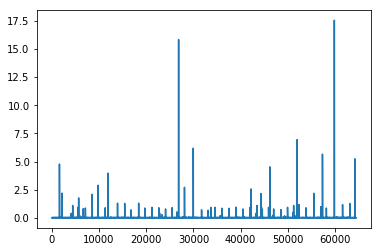

In [23]:
print(X_time.max())
plt.plot(X_time[0])

### Process to neural network 
> center?  
> With what value scale? (min, iqr, std)

In [ ]:
...

In [7]:
#cada curva de luz dividirla por la desviación estandar..
X_lc_scaled = X_lc/X_lc.std(axis=1,keepdims=True)
X_lc_scaled.shape

(8054, 64482)

In [ ]:
# opcion B:
med = np.median(X_lc,axis=1, keepdims=True)
X_lc_scaled = X_lc/(np.median(np.abs(X_lc-med), axis=1, keepdims=True)*1.5)
X_lc_scaled.shape

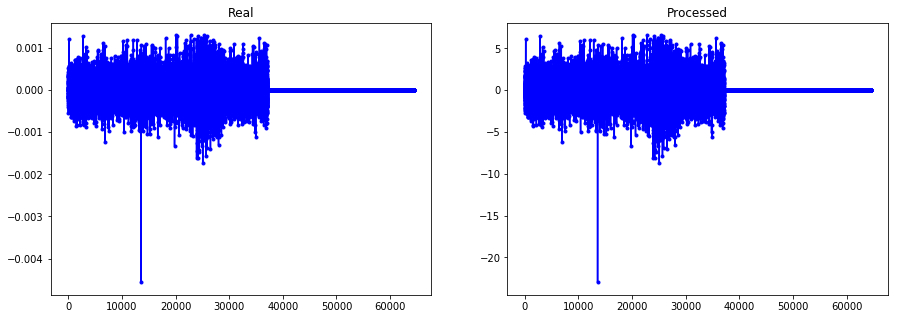

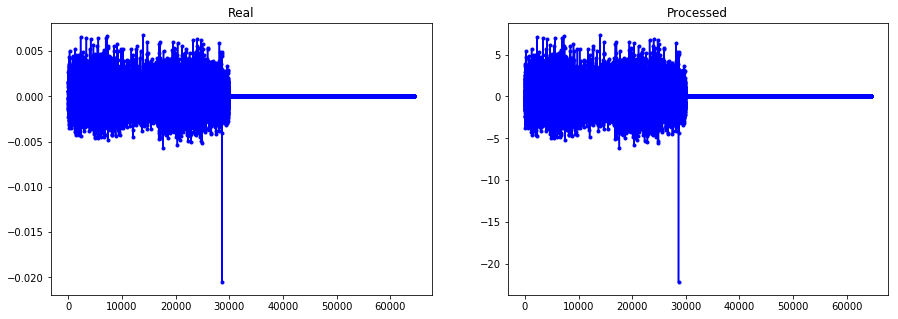

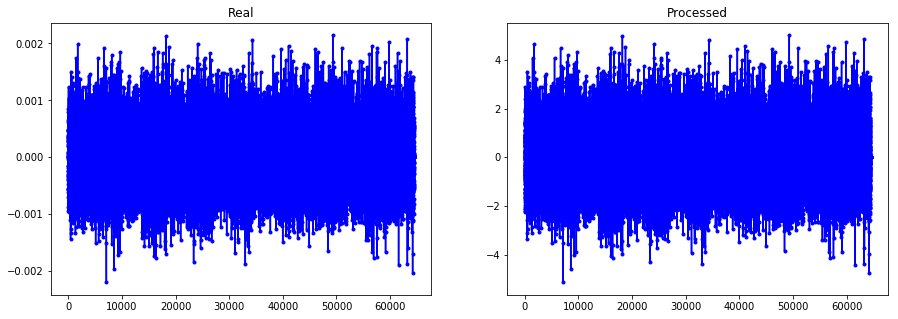

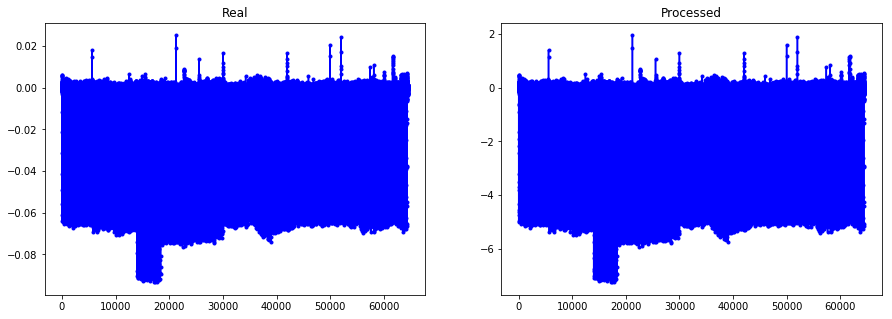

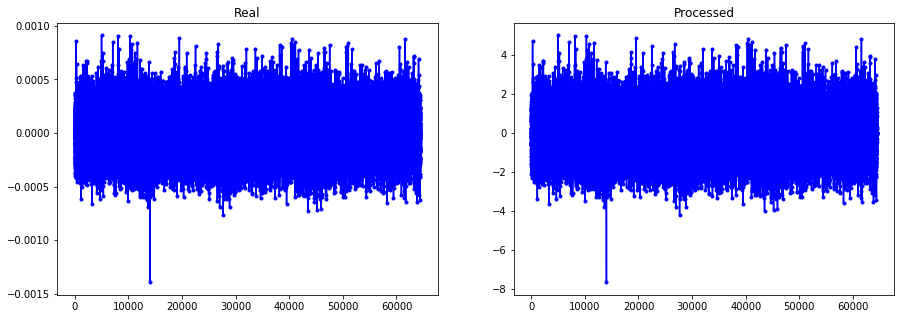

In [8]:
for _ in range(5):
    n_s = np.random.randint(0,X_lc.shape[0])
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize= (15,5))
    ax1.plot(X_lc[n_s], 'b.-')
    ax1.set_title("Real")
    ax2.plot(X_lc_scaled[n_s], 'b.-')
    ax2.set_title("Processed")
    plt.show()

In [9]:
# cómo queda el valor máximo y valor mínimo con la transformación??
print("Mínimo entre todas: ",X_lc_scaled.min())
print("Máximo entre todas: ",X_lc_scaled.max())
plt.boxplot(X_lc_scaled.min(axis=1))
plt.title("Minimo valor")
plt.show()
plt.boxplot(X_lc_scaled.max(axis=1))
plt.title("Maximo valor")
plt.show()

Mínimo entre todas:  -108.514336
Máximo entre todas:  31.178774


In [24]:
min_vals =[]
std_vals = []
mad_vals = []
for i in range(N):
    min_vals.append( coupled_lc[i].min())
    std_vals.append( coupled_lc[i].std() )
    
    med = np.median(coupled_lc[i])
    mad_vals.append( np.median(np.abs(coupled_lc[i]-med)) )

#mientras mas chico sea el valor más aplificara
scale_val = np.min(min_vals) #min of mins...  #va a achicar los valores menores a ese min
print("Min of mins: ",scale_val)

scale_val = np.median(min_vals) #median of mins...  #parece andar mejor.. amplifica ..
print("Median of mins: ",scale_val)

scale_val = np.median(std_vals) #median of std...  amplifica harto los valores
print("Median of std: ",scale_val)

scale_val = np.median(mad_vals) #median of MAD...  amplifica muucho los valores
print("Median of MAD: ",scale_val)

scale_val = np.median(1.5*np.asarray(mad_vals))
print("Median of MAD*1.5: ",scale_val)

Min of mins:  -2.7542897458340634
Median of mins:  -0.002601801502419689
Median of std:  0.0003766413294867889
Median of MAD:  0.0002087929233129331
Median of MAD*1.5:  0.00031318938496939963


In [25]:
scale_val = 0.002601801502419689
X_lc_scaled = X_lc/scale_val
X_lc_scaled.shape

(8054, 64482)

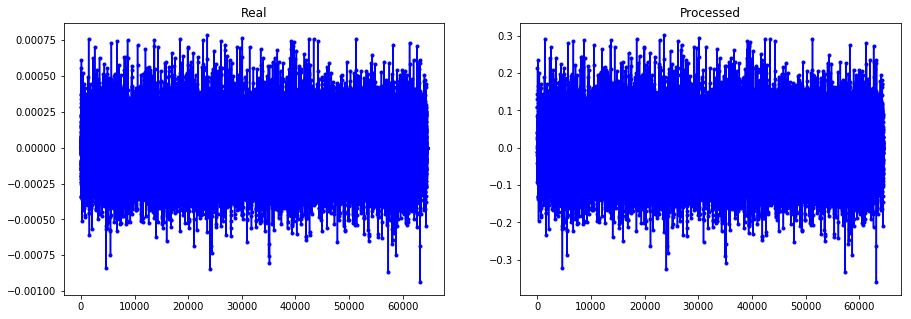

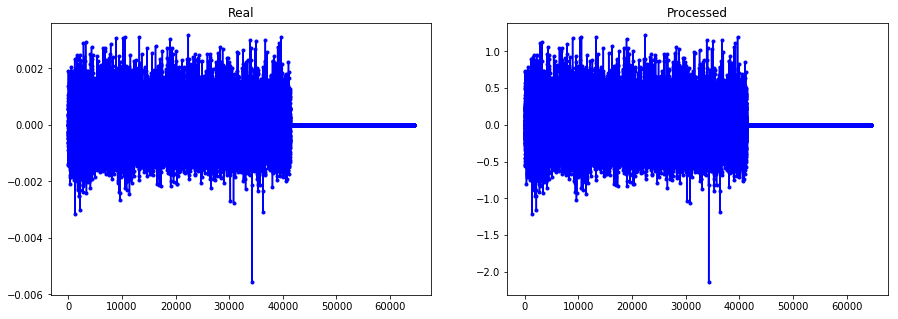

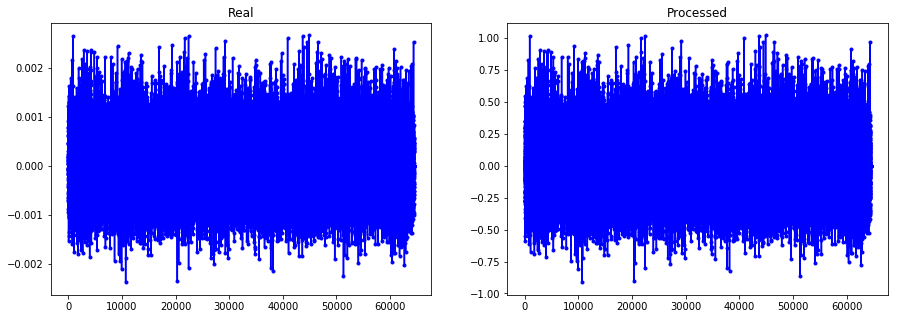

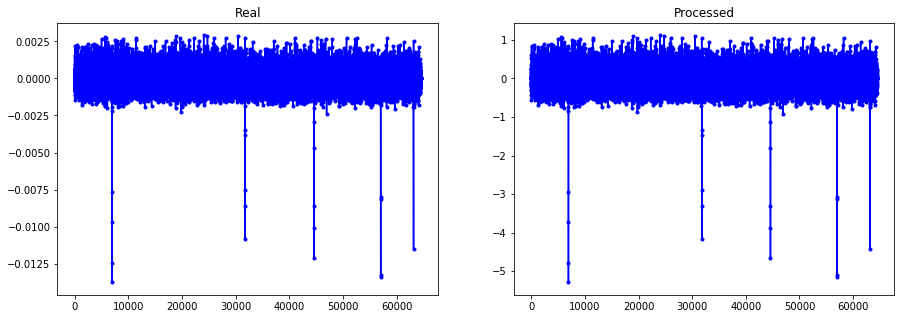

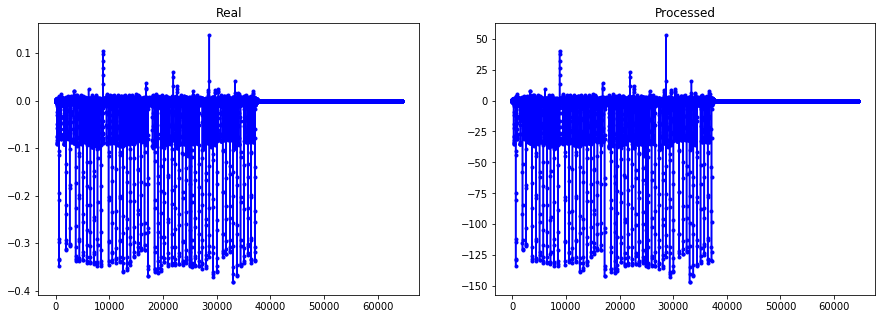

In [26]:
for _ in range(5):
    n_s = np.random.randint(0,X_lc.shape[0])
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize= (15,5))
    ax1.plot(X_lc[n_s], 'b.-')
    ax1.set_title("Real")
    ax2.plot(X_lc_scaled[n_s], 'b.-')
    ax2.set_title("Processed")
    plt.show()

Mínimo entre todas:  -1058.6088
Máximo entre todas:  448.39127


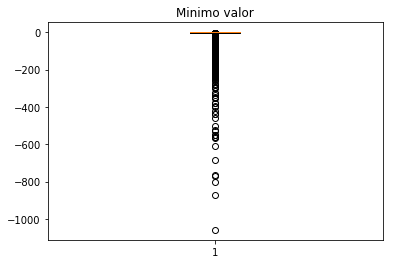

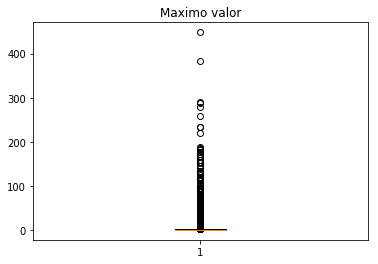

In [27]:
# cómo queda el valor máximo y valor mínimo con la transformación??
print("Mínimo entre todas: ",X_lc_scaled.min())
print("Máximo entre todas: ",X_lc_scaled.max())
plt.boxplot(X_lc_scaled.min(axis=1))
plt.title("Minimo valor")
plt.show()
plt.boxplot(X_lc_scaled.max(axis=1))
plt.title("Maximo valor")
plt.show()

### Define data augmentation
> description..

In [ ]:
def noisify_samples(inputs, outputs, errors, batch_size=500, sample_weight=None):
    """
    inputs: {'main_input': X, 'aux_input': X[:, :, [1]]}
    outputs: X[:, :, [1]]
    errors: X_raw[:, :, 2]
    """
    if sample_weight is None:
        sample_weight = np.ones(errors.shape)
    X = inputs['main_input']
    X_aux = inputs['aux_input']
    shuffle_inds = np.arange(len(X))
    while True:
        # New epoch
        np.random.shuffle(shuffle_inds)
        noise = errors * np.random.normal(size=errors.shape)
        X_noisy = X.copy()
        X_noisy[:, :, 1] += noise
        # Re-scale to have mean 0 and std dev 1; TODO make this optional
        X_noisy[:, :, 1] -= np.atleast_2d(np.nanmean(X_noisy[:, :, 1], axis=1)).T
        X_noisy[:, :, 1] /= np.atleast_2d(np.std(X[:, :, 1], axis=1)).T

        for i in range(ceil(len(X) / batch_size)):
            inds = shuffle_inds[(i * batch_size):((i + 1) * batch_size)]
            yield ([X_noisy[inds], X_aux[inds]], X_noisy[inds, :, 1:2], sample_weight[inds])
            
history = model.fit_generator(noisify_samples(X, Y, errors, batch_size,sample_weight),
                              samples_per_epoch=len(Y), nb_epoch=nb_epoch, validation_data=validation_data)


from keras.utils.data_utils import Sequence
class KOIGenerator(Sequence):
    def __init__(self, x_set, batch_size, flip_p=True, add_n = True, shift=True ):
        self.x = x_set
        self.batch_size = batch_size
        self.flip_p = flip_p
        self.add_n = add_n
        self.shift = shift
        
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return np.stack([self.augment(x) for x in batch_x], axis=0)
            
    def augment(self,x):
        """Do Augmentation"""
        return_x = x.copy()[:,0]
        T = int(return_x.shape[0])
        
        if self.flip_p: #np.random.rand() <= self.flip_p: 
            if np.random.rand() <= 0.5:
                print("Flip")
                return_x = return_x[::-1] #flip
        
        if self.add_n: #np.random.rand() <= self.add_n: 
            if np.random.rand() <= 0.5:
                print("Noise added")
                noise_level =  np.random.uniform(0.01,0.45)
                noise_mask = np.random.binomial(n=1, p=noise_level, size=return_x.shape)
                return_x = return_x[:]*noise_mask
                
        if self.shift:
            if np.random.rand() <= 0.5:
                print("Shift")
                v_shift = np.random.randint(1, int(T*0.49))  #valor a shift?
                return_x = return_x[v_shift:]
                #padd
                return_x = keras.preprocessing.sequence.pad_sequences([return_x], maxlen=T, 
                                    padding='pre', value =0, dtype='float32')[0]
        return return_x[:,None]
                    
# Training data
train_gen = KOIGenerator(X_train, 128)

# Validation data
valid_gen = KOIGenerator(X_test, 128, flip_p = False, add_n = False, shift=False)


# Training
autoencoder.fit_generator(
    train_gen,
    epochs=20,
    validation_data=valid_gen,
    workers=10, use_multiprocessing=True)

In [8]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Conv1D, Dense, Flatten, MaxPool1D, Reshape, UpSampling1D, Lambda
from keras.layers import GlobalAveragePooling1D,GlobalMaxPool1D, TimeDistributed, GRU,LSTM, RepeatVector
from keras.layers import BatchNormalization, Dropout, ZeroPadding1D, ZeroPadding2D, Cropping1D, Cropping2D

D_dim = 8

In [9]:
#need data with extra dim
X_lc = np.expand_dims(np.squeeze(X_lc),axis=-1)
X_lc_scaled = np.expand_dims(np.squeeze(X_lc_scaled),axis=-1)
X_time = np.expand_dims(np.squeeze(X_time),axis=-1)

T = X_lc.shape[1]
channels = 2
X_lc.shape

(8054, 64482, 1)

In [55]:
## define model
def encoder_model_CNN1D(input_dim, channels, latent_dim, L=1, filters=8, kernel_s =10, pool=5,
                        BN = False, conv_pool=False,drop=0 ): #parametros estructurales
    it = Input(shape=(input_dim,channels))  #fixed length..
    f1 = Conv1D(filters, kernel_s, strides=1, padding='same', activation='relu')(it)
    if BN:
        f1 = BatchNormalization()(f1)
    f1 = Conv1D(filters, kernel_s, strides=1, padding='same', activation='relu')(f1)
    if BN:
        f1 = BatchNormalization()(f1)
    if conv_pool:
        f1 = Conv1D(filters, kernel_s, strides=pool, padding='same')(f1)
        if BN:
            f1 = BatchNormalization()(f1)
    else:
        f1 = MaxPool1D(pool_size=pool, strides=pool, padding='same')(f1) 
    if drop != 0:
        f1 = Dropout(drop)(f1)
        
    for _ in range(L-1):
        filters = int(filters*2)
        f1 = Conv1D(filters, kernel_s, strides=1, padding='same', activation='relu')(f1)
        if BN:
            f1 = BatchNormalization()(f1)
        f1 = Conv1D(filters, kernel_s, strides=1, padding='same', activation='relu')(f1)
        if BN:
            f1 = BatchNormalization()(f1)
        if conv_pool:
            f1 = Conv1D(filters, kernel_s, strides=pool, padding='same')(f1)
            if BN:
                f1 = BatchNormalization()(f1)
        else:
            f1 = MaxPool1D(pool_size=pool, strides=pool, padding='same')(f1) #sacar ultimo maxpooling???
        if drop != 0:
            f1 = Dropout(drop)(f1)
    
    redim_shape = K.int_shape(f1)[1:] 
    d1 = GlobalMaxPool1D()(f1) #or global maxpooling
    out_latent= Dense(latent_dim, activation='linear')(d1)
    return Model(inputs=it, outputs=out_latent), redim_shape

#Conv2d!!!
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D,UpSampling2D
def decoder_model_CNN2D(input_dim, channels, redim_shape, L=1, filters=8, kernel_s=10, pool=5,
                        BN = False, conv_pool=False,drop=0,  T=0, bnaut=False ): #parametros estructurales                        
    it = Input(shape=(input_dim,))
    if bnaut:
        f1 = RepeatVector(redim_shape[0])(it)
    else:
        d1 = Dense(redim_shape[-1], activation='relu')(it)
        f1 = RepeatVector(redim_shape[0])(d1)
    
    #agregar dim extra para procesar por conv2d
    f1 = Lambda(lambda x: K.expand_dims(x, axis=2))(f1) #along channel axis
    if bnaut:
        f1 = UpSampling2D((pool,1))(f1)
        f1 = Conv2D(redim_shape[-1], (kernel_s,1), strides=1, padding='same', activation='relu')(f1)
        f1 = Conv2D(redim_shape[-1], (kernel_s,1), strides=1, padding='same', activation='relu')(f1)
        L -=1
    
    filters = int(filters*2**(L-1))
    for _ in range(L):
        if conv_pool:
            f1 = Conv2DTranspose(filters, (kernel_s,1), strides=(pool,1), padding='same')(f1)
            if BN:
                f1 = BatchNormalization()(f1)
        else:
            f1 = UpSampling2D((pool,1))(f1)
        f1 = Conv2D(filters, (kernel_s,1), strides=1, padding='same', activation='relu')(f1)
        if BN:
            f1 = BatchNormalization()(f1)
        f1 = Conv2D(filters, (kernel_s,1), strides=1, padding='same', activation='relu')(f1)
        if BN:
            f1 = BatchNormalization()(f1)
        if drop != 0:
            f1 = Dropout(drop)(f1)
        filters = int(filters/2)
    out_x = Conv2D(channels, (kernel_s,1), strides=1, padding='same', activation='linear')(f1)
    #Model(inputs=it, outputs=out_x).summary()
    out_x = Lambda(lambda x: K.squeeze(x, axis=-1))(out_x)
    if T != 0:
        T_model = K.int_shape(out_x)[1]
        delta_T = T - T_model
        
        padd_len = int(np.abs(delta_T/2))
        if np.abs(delta_T) % 2 ==0:
            left_pad = right_pad = padd_len                
        else:
            left_pad = padd_len+1
            right_pad = padd_len
        if delta_T > 0:
            out_x = ZeroPadding1D((left_pad, right_pad))(out_x)
        elif delta_T < 0:
            out_x = Cropping1D((left_pad, right_pad))(out_x)

    return Model(inputs=it, outputs=out_x)

In [45]:
encoder, redim_shape = encoder_model_CNN1D(T, channels, D_dim, 
                                           L=4, filters=8, pool=5, kernel_s=10, BN = False, conv_pool=False) 
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        (None, 64482, 2)          0         
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 64482, 8)          168       
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 64482, 8)          648       
_________________________________________________________________
max_pooling1d_61 (MaxPooling (None, 12897, 8)          0         
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 12897, 16)         1296      
_________________________________________________________________
conv1d_124 (Conv1D)          (None, 12897, 16)         2576      
_________________________________________________________________
max_pooling1d_62 (MaxPooling (None, 2580, 16)          0         
__________

In [46]:
redim_shape

(104, 64)

In [47]:
decoder = decoder_model_CNN2D(D_dim, 1, redim_shape,
                              L=4, filters=8, pool=5, kernel_s=10, BN = False, conv_pool=True, T=T)
decoder.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        (None, 8)                 0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                576       
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 104, 64)           0         
_________________________________________________________________
lambda_29 (Lambda)           (None, 104, 1, 64)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 520, 1, 64)        41024     
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 520, 1, 64)        41024     
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 520, 1, 64)        41024     
__________

In [14]:
it_lc = Input(shape=X_lc.shape[1:])
it_time = Input(shape=X_time.shape[1:])
it_all = keras.layers.Concatenate()([it_lc,it_time])
out = decoder(encoder(it_all))
autoencoder = Model([it_lc,it_time],out)
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64482, 1)     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 64482, 1)     0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 64482, 2)     0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 8)            82200       concatenate_1[0][0]              
__________

In [ ]:
# ver que pasa si en el decoder agrego el tiempo.. una capa extra arriba
it_model = Input(shape=(T,1))
it_time = Input(shape=(T,1))

f1 = keras.layers.Concatenate()([it_model,it_time])

f1 = Conv1D(1, 10, strides=1, padding='same', activation='linear' )(f1) # o mas capas de estas...

decoder_time = Model(inputs=[it_model,it_time], outputs=f1)
decoder_time.summary()

it = Input(shape=X_all.shape[1:])
it_time = Input(shape=X_all.shape[1:])

out = decoder(encoder(it))

out_time = decoder_time([out,it_time])
autoencoder = Model([it,it_time],out_time)
autoencoder.summary()

In [15]:
def mse_masked(y_true, y_pred):
    """ Masked on 0 value.."""
    mask = K.equal(y_true, 0) #  K.all(, axis=-1)
    mask = 1 - K.cast(mask, K.floatx())

    se_masked = K.square(y_pred-y_true)* mask  #K.multiply(K.square(y_pred-y_true), mask) #square error    
    return K.mean(se_masked, axis=-1)

def train_model(model,X,y,epochs=1,batch_size=32, val_split=0.2):
    return model.fit(X,y, epochs=epochs, batch_size=batch_size, validation_split=val_split)

autoencoder.compile(loss=[mse_masked],optimizer='adam')

### train model (1era fase)

In [17]:
print("Arquitectura: Shallue")
encoder, redim_shape = encoder_model_CNN1D(T, channels, D_dim, L=5, filters=16, pool=2,kernel_s=5,BN=False, conv_pool=False) 
decoder = decoder_model_CNN2D(D_dim, 1, redim_shape, L=5, filters=16, pool=2, kernel_s=5, BN=False, conv_pool=False,T=T)

it_lc = Input(shape=X_lc.shape[1:])
it_time = Input(shape=X_time.shape[1:])
it_all = keras.layers.Concatenate()([it_lc,it_time])
out = decoder(encoder(it_all))
autoencoder = Model([it_lc,it_time],out)

autoencoder.compile(loss=mse_masked, optimizer='adam') 
train_model(autoencoder, [X_lc_scaled,X_time], X_lc_scaled, batch_size=128, epochs=15) 

Arquitectura: Shallue
Train on 6443 samples, validate on 1611 samples
Epoch 1/15
6443/6443 [==============================] - 2488s 386ms/step - loss: 1.0056 - val_loss: 1.0045
Epoch 2/15
6443/6443 [==============================] - 2412s 374ms/step - loss: 1.0044 - val_loss: 1.0015
Epoch 3/15
6443/6443 [==============================] - 2299s 357ms/step - loss: 1.0003 - val_loss: 0.9995
Epoch 4/15
6443/6443 [==============================] - 2297s 356ms/step - loss: 0.9994 - val_loss: 0.9995
Epoch 5/15
6443/6443 [==============================] - 2281s 354ms/step - loss: 0.9994 - val_loss: 0.9993
Epoch 6/15
6443/6443 [==============================] - 2277s 353ms/step - loss: 0.9991 - val_loss: 0.9993
Epoch 7/15
6443/6443 [==============================] - 2280s 354ms/step - loss: 0.9991 - val_loss: 0.9994
Epoch 8/15
6443/6443 [==============================] - 2273s 353ms/step - loss: 0.9993 - val_loss: 1.0000
Epoch 9/15
6443/6443 [==============================] - 2281s 354ms/step -

In [ ]:
print("Arquitectura: C Aguirre con pool sin densas")
encoder, redim_shape = encoder_model_CNN1D(T, channels, D_dim, L=2, filters=32, pool=2,kernel_s=42,BN=False, conv_pool=False) 
decoder = decoder_model_CNN2D(D_dim, 1, redim_shape, L=2, filters=32, pool=2, kernel_s=42, BN=False, conv_pool=False,T=T)

it_lc = Input(shape=X_lc.shape[1:])
it_time = Input(shape=X_time.shape[1:])
it_all = keras.layers.Concatenate()([it_lc,it_time])
out = decoder(encoder(it_all))
autoencoder = Model([it_lc,it_time],out)

autoencoder.compile(loss=mse_masked, optimizer='adam') 
train_model(autoencoder, [X_lc_scaled,X_time], X_lc_scaled, batch_size=128, epochs=15) 

Arquitectura: C Aguirre con pool sin densas
Train on 6443 samples, validate on 1611 samples
Epoch 1/15
6443/6443 [==============================] - 9117s 1s/step - loss: 0.5449 - val_loss: 1.4322e-04
Epoch 2/15
6443/6443 [==============================] - 9119s 1s/step - loss: 1.9376e-04 - val_loss: 1.4227e-04
Epoch 3/15
6443/6443 [==============================] - 9127s 1s/step - loss: 1.9336e-04 - val_loss: 1.4236e-04
Epoch 4/15
6443/6443 [==============================] - 9085s 1s/step - loss: 1.9310e-04 - val_loss: 1.4209e-04
Epoch 5/15
5888/6443 [==========================>...] - ETA: 12:40 - loss: 1.8513e-04

In [ ]:
print("Arquitectura: Schanche")
encoder, redim_shape = encoder_model_CNN1D(T, channels, D_dim, L=2, filters=8, pool=2,kernel_s=8,BN=False, conv_pool=False) 
decoder = decoder_model_CNN2D(D_dim, 1, redim_shape, L=2, filters=8, pool=2, kernel_s=8, BN=False, conv_pool=False,T=T)

it_lc = Input(shape=X_lc.shape[1:])
it_time = Input(shape=X_time.shape[1:])
it_all = keras.layers.Concatenate()([it_lc,it_time])
out = decoder(encoder(it_all))
autoencoder = Model([it_lc,it_time],out)

autoencoder.compile(loss=mse_masked, optimizer='adam') 
train_model(autoencoder, [X_lc_scaled,X_time], X_lc_scaled, batch_size=128, epochs=15) 

In [ ]:
print("Arquitectura: B Naut adaptada a CNN")
encoder, redim_shape = encoder_model_CNN1D(T, channels, D_dim, L=2, filters=32, pool=2,kernel_s=10,BN=False, conv_pool=False) 
decoder = decoder_model_CNN2D(D_dim, 1, redim_shape, L=2, filters=32, pool=2, kernel_s=10, BN=False, conv_pool=False,T=T)

it_lc = Input(shape=X_lc.shape[1:])
it_time = Input(shape=X_time.shape[1:])
it_all = keras.layers.Concatenate()([it_lc,it_time])
out = decoder(encoder(it_all))
autoencoder = Model([it_lc,it_time],out)

autoencoder.compile(loss=mse_masked, optimizer='adam') 
train_model(autoencoder, [X_lc_scaled,X_time], X_lc_scaled, batch_size=128, epochs=15) 

In [ ]:
print("Arquitectura: Idea Mia")
#kernel de 10, ya que el minimo periodo es de 15 puntos.. en Kepler
encoder, redim_shape = encoder_model_CNN1D(T, channels, D_dim, L=5, filters=8, pool=2,kernel_s=10,BN=False, conv_pool=False) 
decoder = decoder_model_CNN2D(D_dim, 1, redim_shape, L=5, filters=8, pool=2, kernel_s=10, BN=False, conv_pool=False,T=T)

it_lc = Input(shape=X_lc.shape[1:])
it_time = Input(shape=X_time.shape[1:])
it_all = keras.layers.Concatenate()([it_lc,it_time])
out = decoder(encoder(it_all))
autoencoder = Model([it_lc,it_time],out)

autoencoder.compile(loss=mse_masked, optimizer='adam') 
train_model(autoencoder, [X_lc_scaled,X_time], X_lc_scaled, batch_size=128, epochs=15) 

In [ ]:
### modelo que toma el tiempo como input aparte (pesos compartidos ) y los combina en el decoder (concat/sum/mult)

In [49]:
encoder, redim_shape = encoder_model_CNN1D(T, 1, D_dim, L=5, filters=8, pool=2,kernel_s=10,BN=False, conv_pool=False) 

it_lc = Input(shape=X_lc.shape[1:])
it_time = Input(shape=X_time.shape[1:])
encoder_lc = encoder(it_lc)
encoder_time = encoder(it_time)

aux = keras.layers.Concatenate()([encoder_lc,encoder_time])
decoder = decoder_model_CNN2D(D_dim*2, 1, redim_shape, L=5, filters=8, pool=2, kernel_s=10, BN=False, conv_pool=False,T=T)

#aux = keras.layers.Add()([encoder_lc,encoder_time])
#aux = keras.layers.Multiply()([encoder_lc,encoder_time])
#decoder = decoder_model_CNN2D(D_dim, 1, redim_shape, L=5, filters=8, pool=2, kernel_s=10, BN=False, conv_pool=False,T=T)

out = decoder(aux)
autoencoder = Model([it_lc,it_time],out)
autoencoder.summary()
#autoencoder.compile(loss=mse_masked, optimizer='adam') 
#train_model(autoencoder, [X_lc_scaled,X_time], X_lc_scaled, batch_size=128, epochs=15) 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_63 (InputLayer)           (None, 64482, 1)     0                                            
__________________________________________________________________________________________________
input_64 (InputLayer)           (None, 64482, 1)     0                                            
__________________________________________________________________________________________________
model_42 (Model)                (None, 8)            328648      input_63[0][0]                   
                                                                 input_64[0][0]                   
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 16)           0           model_42[1][0]                   
          

In [42]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 64482, 1)          0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 64482, 8)          88        
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 64482, 8)          648       
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 32241, 8)          0         
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 32241, 16)         1296      
_________________________________________________________________
conv1d_114 (Conv1D)          (None, 32241, 16)         2576      
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 16121, 16)         0         
__________

In [50]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        (None, 16)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               2176      
_________________________________________________________________
repeat_vector_18 (RepeatVect (None, 2016, 128)         0         
_________________________________________________________________
lambda_35 (Lambda)           (None, 2016, 1, 128)      0         
_________________________________________________________________
up_sampling2d_67 (UpSampling (None, 4032, 1, 128)      0         
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 4032, 1, 128)      163968    
_________________________________________________________________
conv2d_167 (Conv2D)          (None, 4032, 1, 128)      163968    
__________

In [56]:
decoder = decoder_model_CNN2D(D_dim, 1, redim_shape, L=5, filters=8, pool=2, kernel_s=10,T=T, bnaut=True)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        (None, 8)                 0         
_________________________________________________________________
repeat_vector_21 (RepeatVect (None, 2016, 8)           0         
_________________________________________________________________
lambda_41 (Lambda)           (None, 2016, 1, 8)        0         
_________________________________________________________________
up_sampling2d_81 (UpSampling (None, 4032, 1, 8)        0         
_________________________________________________________________
conv2d_200 (Conv2D)          (None, 4032, 1, 128)      10368     
_________________________________________________________________
conv2d_201 (Conv2D)          (None, 4032, 1, 128)      163968    
_________________________________________________________________
up_sampling2d_82 (UpSampling (None, 8064, 1, 128)      0         
__________

In [ ]:
### lo mismo de arriba pero las mediciones tambien son "deltas"... sin desviacion estandar..

### evaluate with loss and measure acc on labeled data

In [21]:
def plot_n_lc(real_lc, decoded_lc, n = 10):
    for _ in range(n):
        n_sampled = np.random.randint(0, real_lc.shape[0])
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize= (15,5))
        ax1.plot(real_lc[n_sampled], 'bo-')
        ax1.set_title("Real")
        ax2.plot(decoded_lc[n_sampled], 'bo-')
        ax2.set_title("Reconstructed")
        plt.show()

        plt.figure(figsize=(15,5))
        plt.plot(real_lc[n_sampled], 'bo-', label="Real")
        plt.plot(decoded_lc[n_sampled], 'g*-', label="Reconstructed")
        plt.title("Over")
        plt.legend()
        plt.show()
        print("----------------------------------------------------------------")

In [22]:
%%time
X_encoder = encoder.predict(np.concatenate([X_lc_scaled,X_time],axis=-1),batch_size=128)
X_encoder

CPU times: user 53min 13s, sys: 14min 15s, total: 1h 7min 29s
Wall time: 3min 43s


In [19]:
X_encoder = encoder.predict(np.concatenate([X_lc_scaled[:32],X_time[:32]],axis=-1))
X_lc_hat = np.squeeze(decoder.predict(X_encoder))

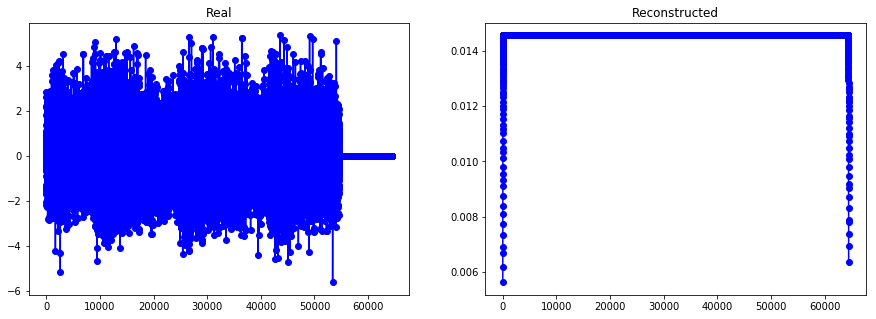

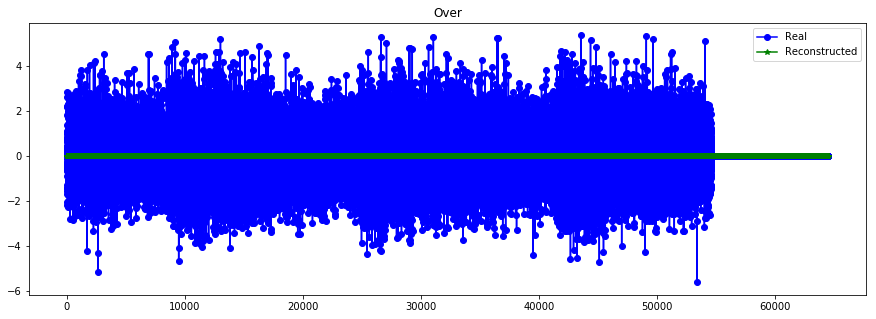

----------------------------------------------------------------


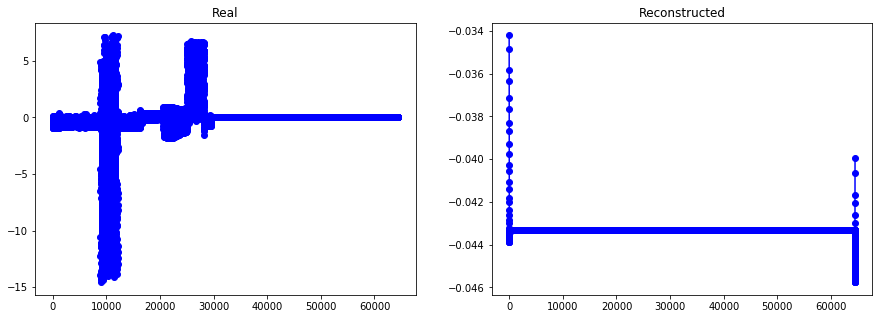

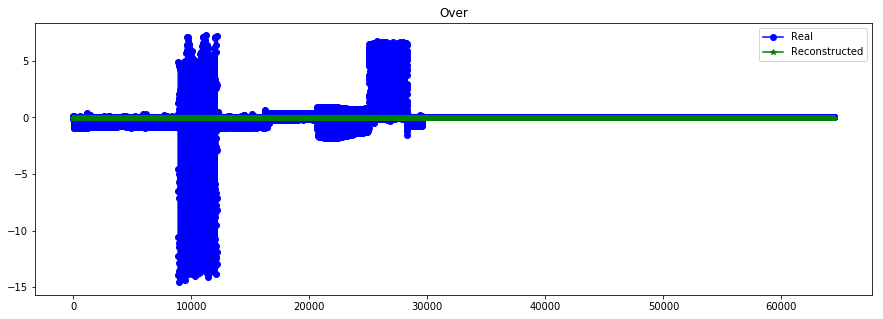

----------------------------------------------------------------


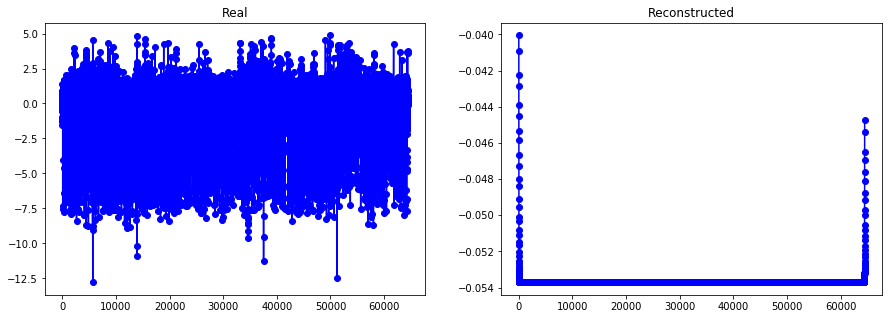

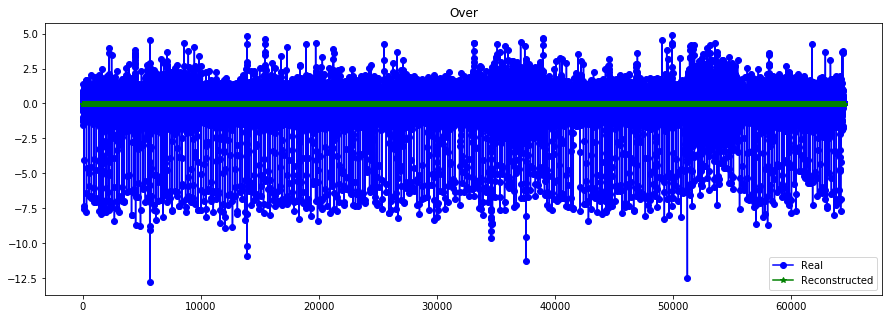

----------------------------------------------------------------


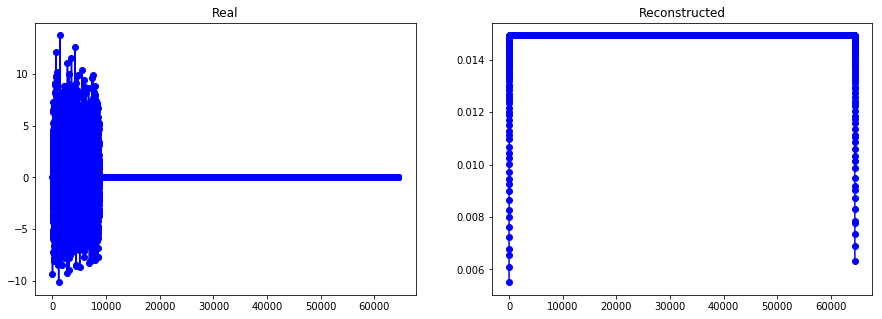

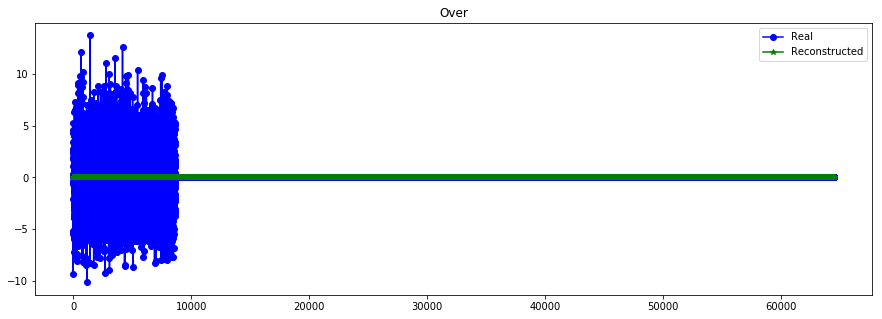

----------------------------------------------------------------


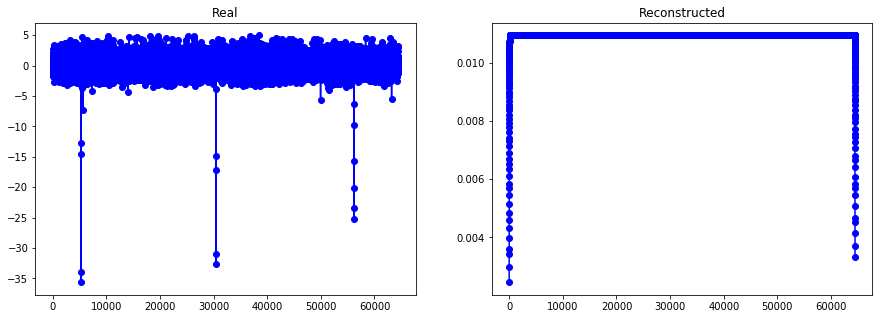

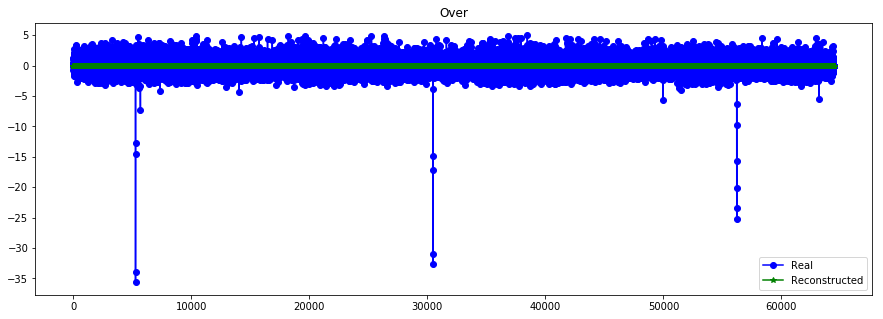

----------------------------------------------------------------


In [20]:
plot_n_lc(X_lc_scaled[:32], X_lc_hat, n= 5)

In [24]:
X_encoder = encoder.predict(np.concatenate([X_lc_scaled[:32],X_time[:32]],axis=-1))
X_lc_hat = np.squeeze(decoder.predict(X_encoder))

In [ ]:
plot_n_lc(X_lc_scaled[:32], X_lc_hat, n= 5)

In [ ]:
### load metadata

In [ ]:
#pre-process: scale metadata

In [ ]:
### train model (2da fase)

In [ ]:
### evaluate with mse between metadata (and the values before)